# MODULE 3
## Milestone 1: exploration phase

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use("ggplot")

In [21]:
box_builder_sample_data = '/home/unai/datasets/feature_frame.csv'
bb_df = pd.read_csv(box_builder_sample_data)
bb_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [22]:
bb_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [4]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [23]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [6]:
bb_df[categorical_cols].describe()

,product_type,vendor
count,2880549,2880549
unique,62,264
top,tinspackagedfoods,biona
freq,226474,146828


##### Categorical variables have very high cardinality. We are goning to use frequency encoding.

In [24]:
bb_df.product_type.replace(((bb_df['product_type'].value_counts()/len(bb_df)*100).round(5)).to_dict(), inplace=True)
bb_df.vendor.replace(((bb_df['vendor'].value_counts()/len(bb_df)*100).round(5)).to_dict(), inplace=True)

In [25]:
# We only keep orders with at least 5 items
orders = bb_df['order_id'].unique()
orders_more5 = orders[bb_df.groupby('order_id')['outcome'].sum() >= 5]
bb_df = bb_df.loc[bb_df['order_id'].isin(orders_more5)]

In [26]:
bb_df[label_col].value_counts()/len(bb_df)*100

outcome
0.0    98.552233
1.0     1.447767
Name: count, dtype: float64

##### Unbalanced problem --> We must mantain the porcentage in train, validation and testing datasets

In [27]:
# We avoid information leakage in train and test datasets of different users
users = bb_df['user_id'].unique()
users_train, users_validation, users_test = np.split(users, [int(.6 * len(users)), int(.78 * len(users))])

In [29]:
train = bb_df[bb_df['user_id'].isin(users_train)].reset_index()
X_train = train[features_cols]
Y_train = train[label_col]

validation = bb_df[bb_df['user_id'].isin(users_validation)].reset_index()
X_validation = validation[features_cols]
Y_validation = validation[label_col]

test = bb_df[bb_df['user_id'].isin(users_test)].reset_index()
X_test = test[features_cols]
Y_test = test[label_col]

In [30]:
print(f"Value counts train: {(Y_train.value_counts()/len(Y_train)*100).to_dict()}")
print(f"Value counts validation: {(Y_validation.value_counts()/len(Y_validation)*100).to_dict()}")
print(f"Value counts test: {(Y_test.value_counts()/len(Y_test)*100).to_dict()}")

Value counts train: {0.0: 98.48475974586931, 1.0: 1.5152402541306886}
Value counts validation: {0.0: 98.674001140962, 1.0: 1.3259988590379859}
Value counts test: {0.0: 98.73850229644577, 1.0: 1.2614977035542296}


##### We keep the balance in the training, validation and testing datasets

## TESTING DIFFERENT MODELS

In [41]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay

In [59]:
regr = linear_model.LogisticRegression(max_iter=250)
regr.fit(X_train, Y_train)

/home/unai/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=250)

In [60]:
regr.coef_

array([[ 3.57493341e-02, -6.89855839e-02,  2.71194491e+00,
         5.12447178e+00,  8.83803238e-03,  1.82445978e+00,
        -2.46291620e+00,  3.05910817e-01, -1.12551978e-02,
         2.16274152e+00, -4.17145100e-02,  2.65358116e-03,
         9.18054667e-02,  9.87874506e-02, -3.90609288e-02,
        -1.21015183e-02, -1.93623980e-02,  4.07025579e-03,
         5.32724075e-03, -1.41717316e-02, -2.51541216e-02]])

In [93]:
Y_prob = regr.predict_proba(X_validation)

In [88]:
len(Y_prob[:,1])

338311

In [58]:
Y_validation.value_counts()

outcome
0.0    333825
1.0      4486
Name: count, dtype: int64

In [125]:
threshold = 0.025
Y_pred = np.zeros(Y_prob[:,1].shape)
Y_pred[Y_prob[:,1] > threshold] = 1

In [126]:
C = confusion_matrix(Y_validation, Y_pred, normalize='true')

In [115]:
C

array([[98.69512469,  1.30487531],
       [74.96656264, 25.03343736]])

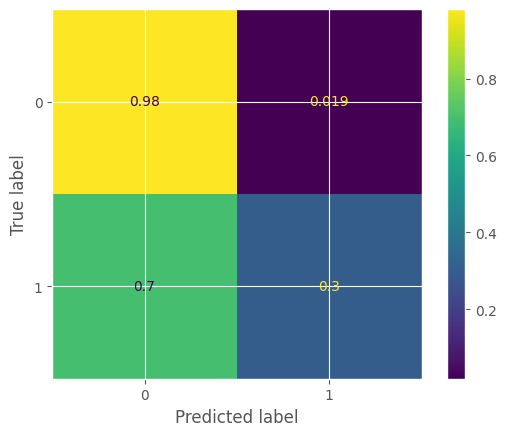

In [127]:
disp = ConfusionMatrixDisplay(C)
disp.plot()
plt.show()